# Assignment 2 - Leonardo Stoppani
### Plot the auto-correlogram of the temperature data in the appliances [dataset](https://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction#)

### Get Data
First we extract the temperatures data of the 9 sensors.

In [1]:
# import the dataset 
import pandas as pd

df = pd.read_csv(r'./energydata_complete.csv', parse_dates=['date'], index_col='date')

# define dict for sensors name 
sensors = {1:"Kitchen", 2:"Living", 3:"Laundry", 4:"Office", 5:"Bathroom", 
           6:"Outside North", 7:"Ironing", 8:"Teenager", 9:"Parents",}

print(df.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19735 entries, 2016-01-11 17:00:00 to 2016-05-27 18:00:00
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Appliances   19735 non-null  int64  
 1   lights       19735 non-null  int64  
 2   T1           19735 non-null  float64
 3   RH_1         19735 non-null  float64
 4   T2           19735 non-null  float64
 5   RH_2         19735 non-null  float64
 6   T3           19735 non-null  float64
 7   RH_3         19735 non-null  float64
 8   T4           19735 non-null  float64
 9   RH_4         19735 non-null  float64
 10  T5           19735 non-null  float64
 11  RH_5         19735 non-null  float64
 12  T6           19735 non-null  float64
 13  RH_6         19735 non-null  float64
 14  T7           19735 non-null  float64
 15  RH_7         19735 non-null  float64
 16  T8           19735 non-null  float64
 17  RH_8         19735 non-null  float64
 18  T9         

### Plot data
Then we plot the 9 time series for a first look to our data. Sensors data have a lot of noise, so before plotting the auto-correlogram we try to reduce it.

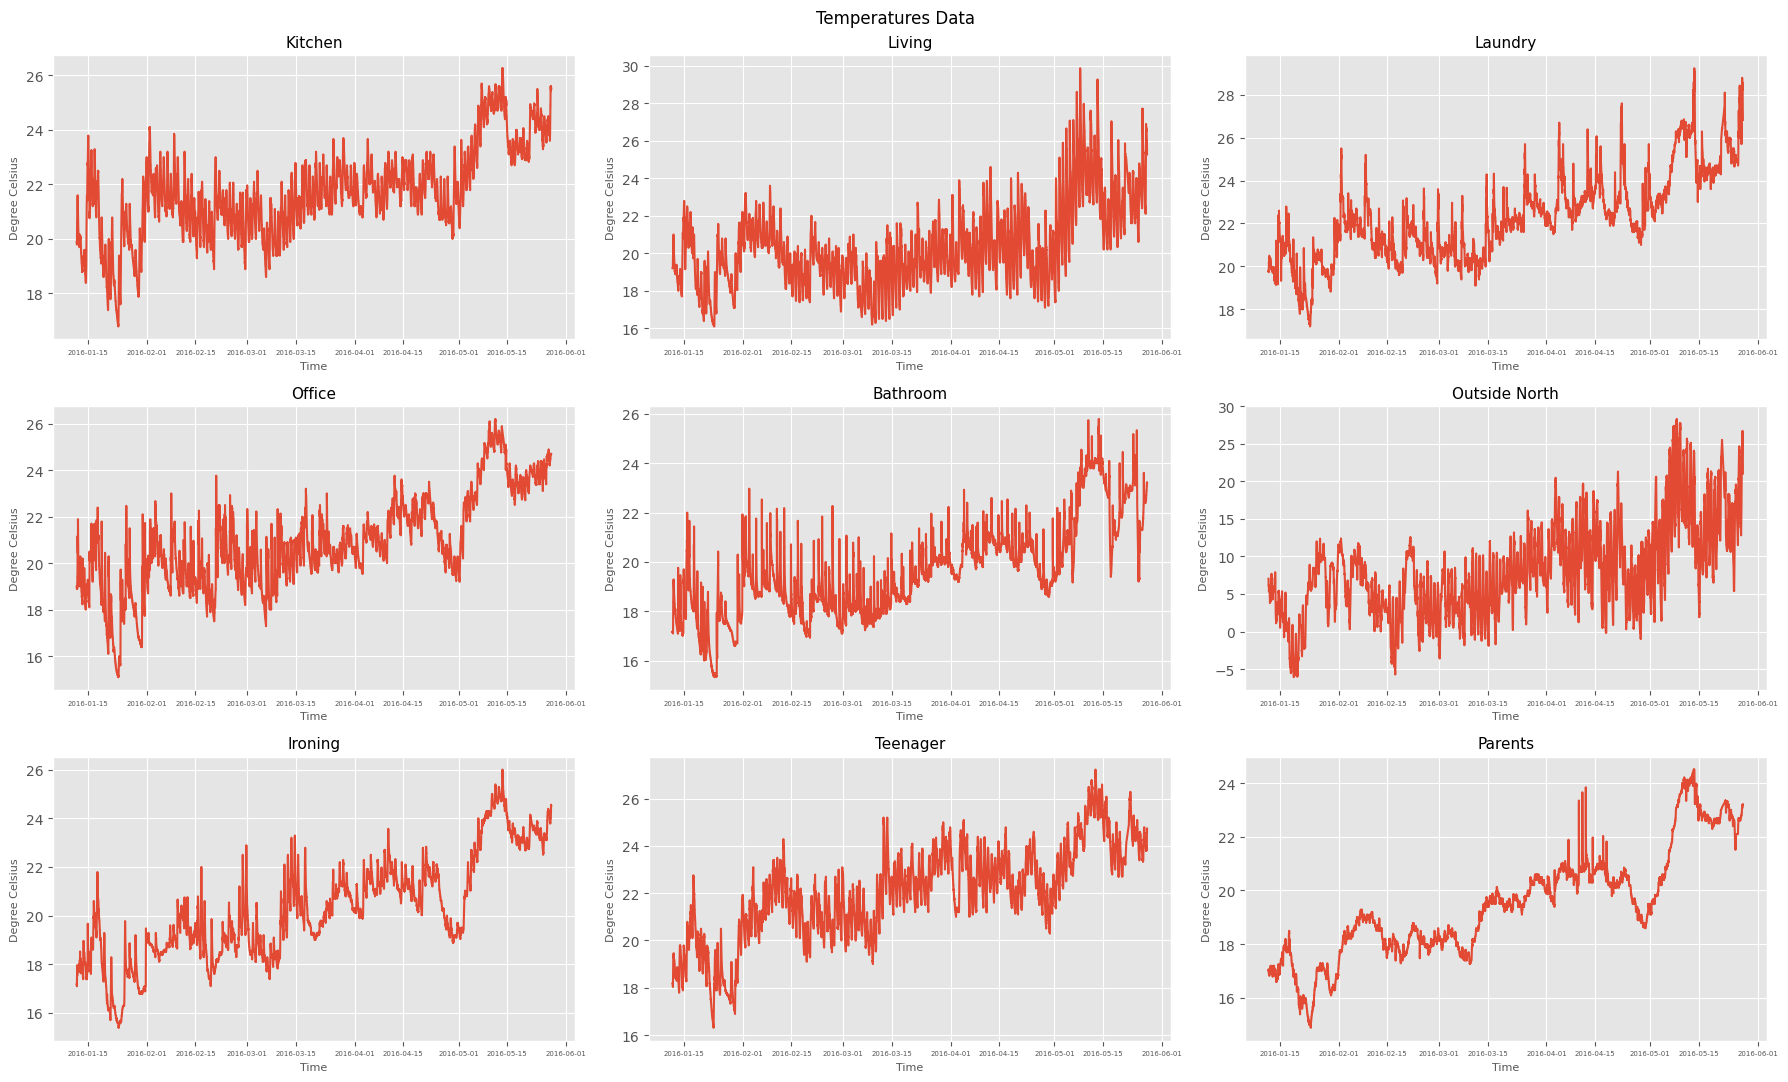

In [2]:
# plot data to understand best lag value (k)
import matplotlib.pyplot as plt
from statsmodels.graphics import tsaplots
import numpy as np

plt.style.use("ggplot")
figure, axis = plt.subplots(3, 3, figsize=(18, 11))

k=0
for i in range(3):
    for j in range(3):
        k+=1
        data = df['T'+str(k)]
        #print(data)
        result = axis[i,j].plot(data)
        axis[i,j].set_title(sensors[k], fontsize=11)
        axis[i,j].set_xlabel("Time", fontsize=8)
        axis[i,j].set_ylabel("Degree Celsius", fontsize=8)
        axis[i,j].tick_params(axis="x", labelsize=5) 

figure.suptitle("Temperatures Data")
figure.tight_layout()
plt.show()


### Clean Data
Noise in the data can be caused by the fine grain measurement. Temperature is affected by small variation wich can make difficult to read data, so we make a subsampling moving from 10 minutes intervals to 1 hour and taking the avarege value. We expect to do this without losing too much information and reducing more the noise.

In [33]:
# subsampling 6 row into 1 and take average temperature every hour
df_sub = df.resample('60T').mean() # one line every hour
print(df_sub.head())
#print(df_sub.info())

                     Appliances     lights         T1       RH_1         T2  \
date                                                                          
2016-01-11 17:00:00   55.000000  35.000000  19.890000  46.502778  19.200000   
2016-01-11 18:00:00  176.666667  51.666667  19.897778  45.879028  19.268889   
2016-01-11 19:00:00  173.333333  25.000000  20.495556  52.805556  19.925556   
2016-01-11 20:00:00  125.000000  35.000000  20.961111  48.453333  20.251111   
2016-01-11 21:00:00  103.333333  23.333333  21.311667  45.768333  20.587778   

                          RH_2         T3       RH_3         T4       RH_4  \
date                                                                         
2016-01-11 17:00:00  44.626528  19.790000  44.897778  18.932778  45.738750   
2016-01-11 18:00:00  44.438889  19.770000  44.863333  18.908333  46.066667   
2016-01-11 19:00:00  46.061667  20.052222  47.227361  18.969444  47.815556   
2016-01-11 20:00:00  45.632639  20.213889  47.268889  19

#### Remove Trend

In [ ]:
#remove trend

#### Discrete Fourier Transform

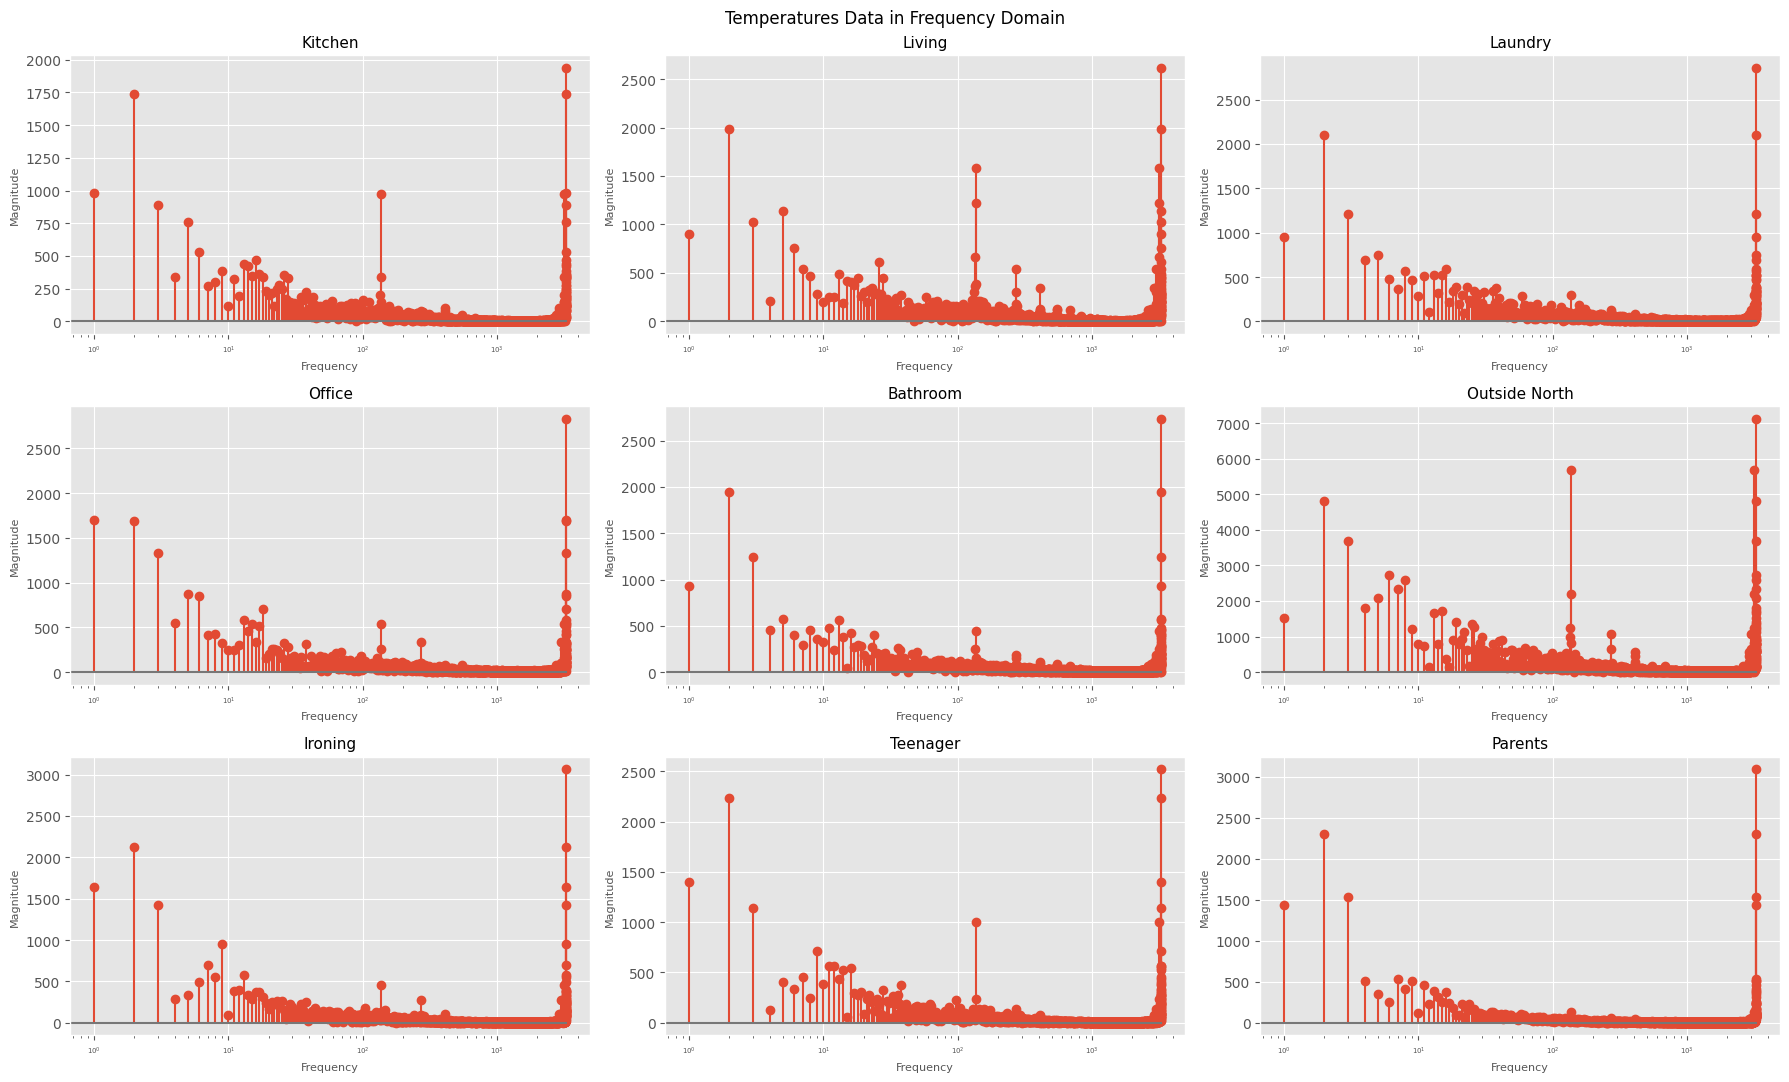

In [49]:
plt.style.use("ggplot")
figure, axis = plt.subplots(3, 3, figsize=(18, 11))

k=0
for i in range(3):
    for j in range(3):
        k+=1
        data = df_sub['T'+str(k)]
        num_samples = len(data.to_numpy())

        #dft
        fft = np.fft.fft(data.to_numpy(), num_samples)

        axis[i,j].stem(abs(fft[1:]))
        #axis[i,j].plot(clean_data)

        axis[i,j].set_title(sensors[k], fontsize=11)
        axis[i,j].set_xlabel("Frequency", fontsize=8)
        axis[i,j].set_ylabel("Magnitude", fontsize=8)
        axis[i,j].tick_params(axis="x", labelsize=5) 
        axis[i,j].set_xscale('log')

figure.suptitle("Temperatures Data in Frequency Domain")
figure.tight_layout()
plt.show()


/opt/homebrew/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


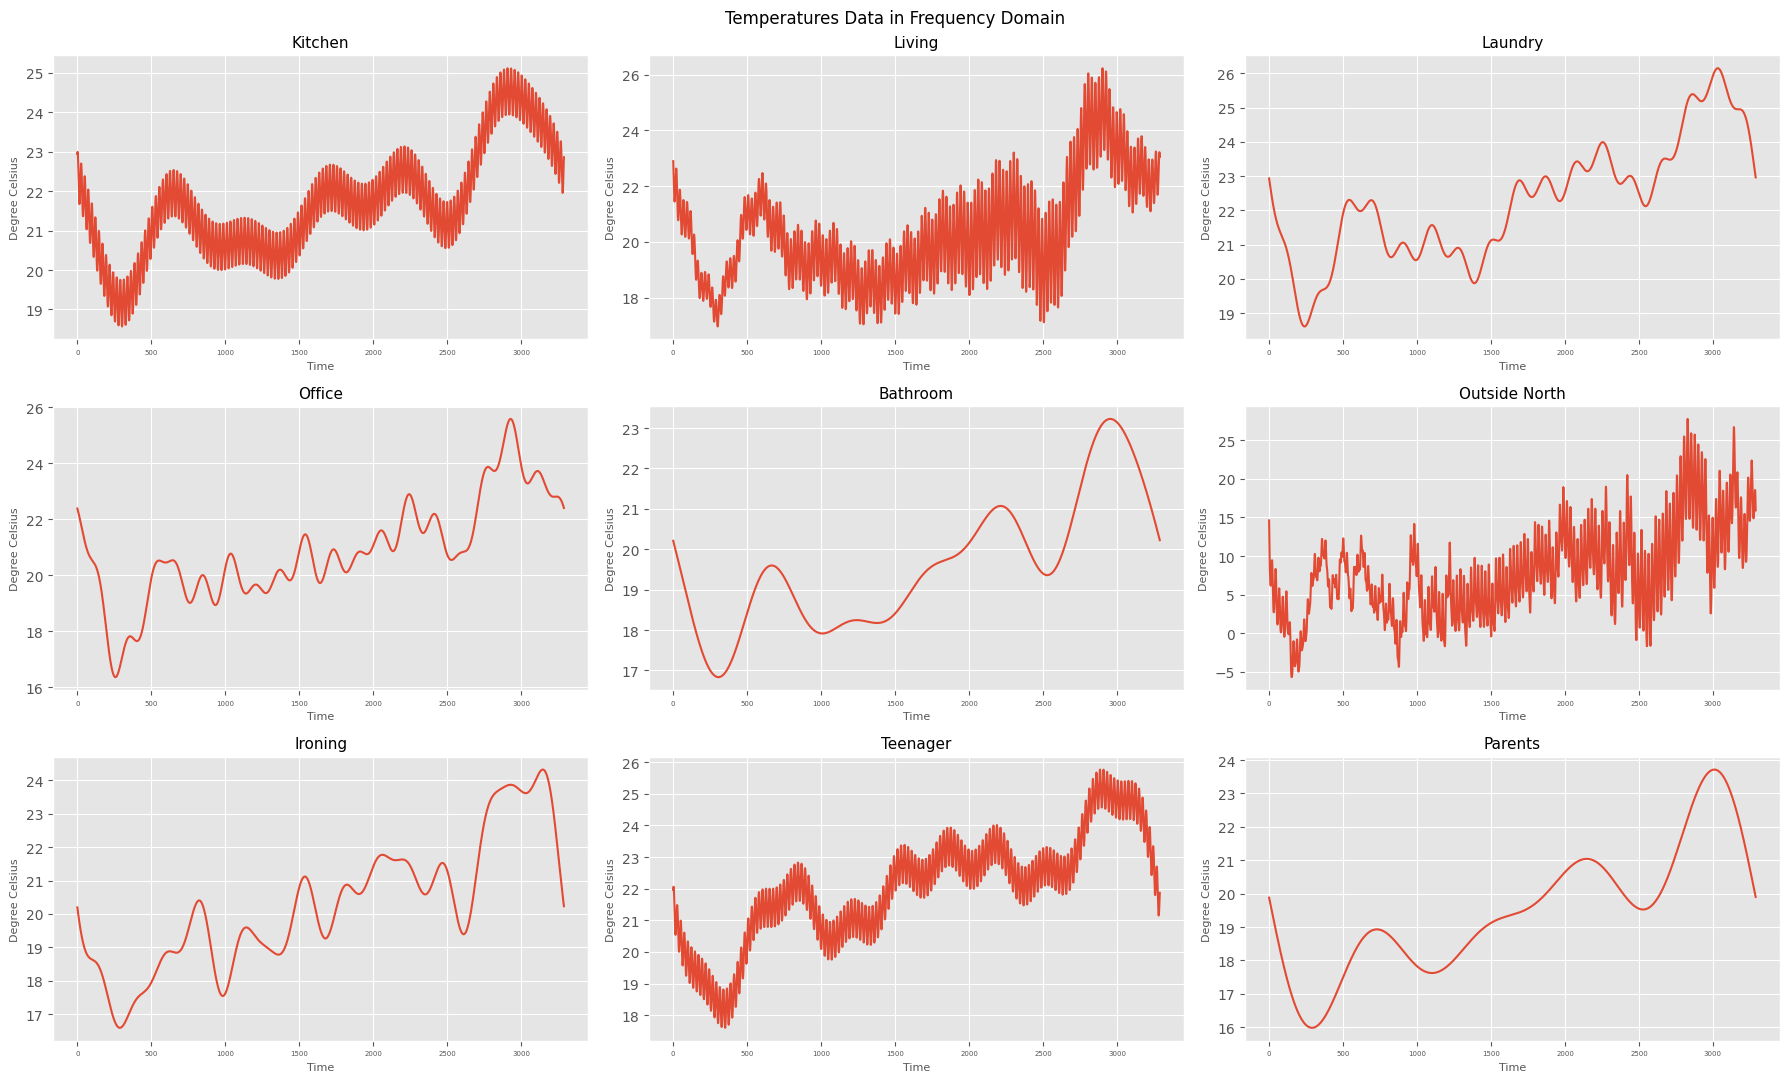

In [57]:
plt.style.use("ggplot")
figure, axis = plt.subplots(3, 3, figsize=(18, 11))

k=0
clean_data = [None]*9
for i in range(3):
    for j in range(3):
        k+=1
        data = df_sub['T'+str(k)]
        num_samples = len(data.to_numpy())

        #dft
        fft = np.fft.fft(data.to_numpy(), num_samples)

        PSD = fft * np.conj(fft) / num_samples

        _mask = PSD > 100
        fft = _mask * fft

        clean_data[k-1]=np.fft.ifft(fft)

        #axis[i,j].stem(abs(fft[1:]))
        axis[i,j].plot(clean_data[k-1])

        axis[i,j].set_title(sensors[k], fontsize=11)
        axis[i,j].set_xlabel("Time", fontsize=8)
        axis[i,j].set_ylabel("Degree Celsius", fontsize=8)
        axis[i,j].tick_params(axis="x", labelsize=5) 
        #axis[i,j].set_xscale('log')

figure.suptitle("Temperatures Data in Frequency Domain")
figure.tight_layout()
plt.show()

### Seasonality Analysis
From time series of house temperatures we expect the value to repeat every day, high temperature by day and low by night. Also the type of mesauration, every 10 minutes for a period of 4.5 months, lead to this type of analysis. We can also try to see if there is a monthly periodicity.

First we try with period equal a month.

In [ ]:
#Period = Month

import statsmodels.api as sm

plt.style.use("ggplot")
figure, axis = plt.subplots(3, 3, figsize=(15, 8))

k=0
for i in range(3):
    for j in range(3):
        k+=1
        data = df['T'+str(k)]
        #print(data)
        decomposition = sm.tsa.seasonal_decompose(data, period=4320) #1 day 144 , 1 month 4320
        decomposition.seasonal.plot(ax=axis[i,j])
        axis[i,j].set_title(sensors[k], fontsize=11)

figure.suptitle("Seasonality of Temperatures (Period=Month)")
figure.tight_layout()
plt.show()



Then we move to period equal a day.

In [ ]:
# Period = 1 Day 
plt.style.use("ggplot")
figure, axis = plt.subplots(3, 3, figsize=(15, 8))

k=0
for i in range(3):
    for j in range(3):
        k+=1
        data = df['T'+str(k)]
        #print(data)
        decomposition = sm.tsa.seasonal_decompose(data, period=144) 
        decomposition.seasonal["2016-03-01 00:00:00":"2016-03-10 00:00:00"].plot(ax=axis[i,j])
        axis[i,j].set_title(sensors[k], fontsize=11)

figure.suptitle("Seasonality of Temperatures (Period=Day)")
figure.tight_layout()
plt.show()

#### Trend Analysis
All the temperatures have a trend from lower to higher caused by the transition from winter to summer.

In [ ]:
plt.style.use("ggplot")
figure, axis = plt.subplots(3, 3, figsize=(15, 8))

k=0
for i in range(3):
    for j in range(3):
        k+=1
        data = df['T'+str(k)]
        #print(data)
        decomposition = sm.tsa.seasonal_decompose(data, period=4320) 
        decomposition.trend.plot(ax=axis[i,j])
        axis[i,j].set_title(sensors[k], fontsize=11)

figure.suptitle("Trends of Temperatures")
figure.tight_layout()
plt.show()

#### Noise
Data from time series have a lot of noise due to the fine grain misuration of the temperatures. In a ten minute interval temperature have small variation which make the data less readable. We can still manage to see how in the Ironing room and Office room the noise tend to deacrese moving to hotter months. In an Ironing room we can expect a quick increase of the temperature for a small amount of time, that is more relevant when the ambient temperature is lower. We observe also a strange behaviour in parents room.

In [ ]:
plt.style.use("ggplot")
figure, axis = plt.subplots(3, 3, figsize=(15, 8))

k=0
for i in range(3):
    for j in range(3):
        k+=1
        data = df['T'+str(k)]
        #print(data)
        decomposition = sm.tsa.seasonal_decompose(data, period=144) 
        decomposition.resid.plot(ax=axis[i,j])
        axis[i,j].set_title(sensors[k], fontsize=11)

figure.suptitle("Noise of Temperatures")
figure.tight_layout()
plt.show()

### Auto-correlation plot
From time series of house temperatures we expect the value to repeat every day, high temperature by day and low by night. Also the type of mesauration, every 10 minutes for a period of 4.5 months, lead to this type of analysis. We can also try to see if there is a monthly periodicity.

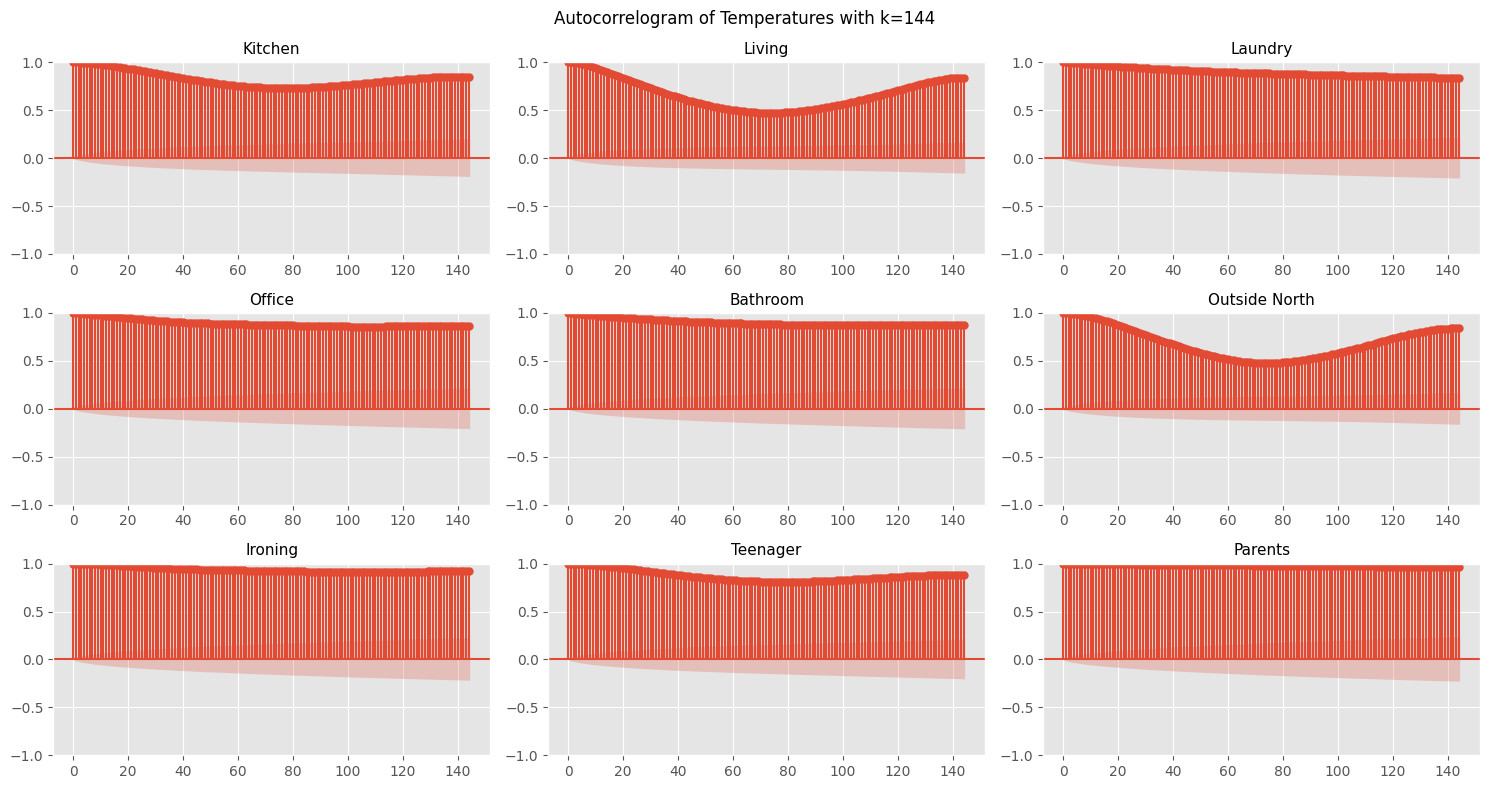

In [60]:
plt.style.use("ggplot")
figure, axis = plt.subplots(3, 3, figsize=(15, 8))

k=0
for i in range(3):
    for j in range(3):
        k+=1
        data = df['T'+str(k)].to_numpy()
        #decomposition = sm.tsa.seasonal_decompose(data, period=144) 
        tsaplots.plot_acf(data, lags = 144, ax=axis[i,j])
        axis[i,j].set_title(sensors[k], fontsize=11)

figure.suptitle("Autocorrelogram of Temperatures with k=144")
figure.tight_layout()
plt.show()


With the subsampled dataset we get a better visualization.

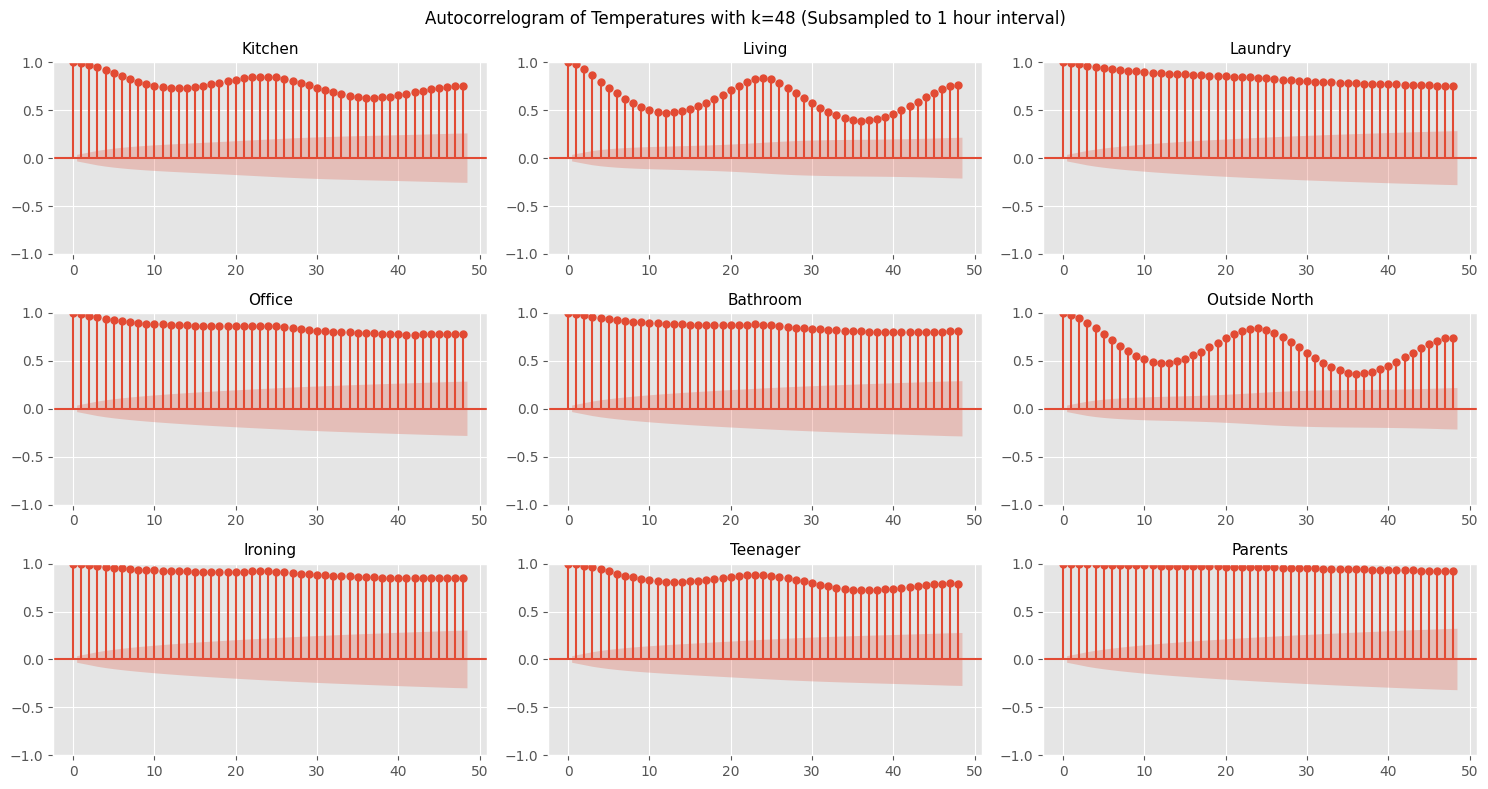

In [30]:
plt.style.use("ggplot")
figure, axis = plt.subplots(3, 3, figsize=(15, 8))

k=0
for i in range(3):
    for j in range(3):
        k+=1
        data = df_sub['T'+str(k)].to_numpy()
        # now we have 1 hour interval
        #decomposition = sm.tsa.seasonal_decompose(data, period=168) #1 week 168, 1 day 24, 1 month 720, 5 day 120
        tsaplots.plot_acf(data, lags = 48, ax=axis[i,j])
        axis[i,j].set_title(sensors[k], fontsize=11)

figure.suptitle("Autocorrelogram of Temperatures with k=48 (Subsampled to 1 hour interval)")
figure.tight_layout()
plt.show()